In [1]:
import os
import random
import torch as tch
import torch.nn as tchnn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as tchoptim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.autograd as tchagd
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import scipy as sp
from scipy.misc import imresize

In [52]:
z_indim = 100
ngf = 64
nc = 1
ndf = 64

In [53]:
class Generator(tchnn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = tchnn.Sequential(
            # input is Z, going into a convolution
            tchnn.ConvTranspose2d(z_indim, ngf*8, 4, 1, 0, bias=False),
            tchnn.BatchNorm2d(ngf*8),
            tchnn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            tchnn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            tchnn.BatchNorm2d(ngf*4),
            tchnn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            tchnn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            tchnn.BatchNorm2d(ngf*2),
            tchnn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            tchnn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            tchnn.BatchNorm2d(ngf),
            tchnn.ReLU(True),
            # state size. (ngf) x 32 x 32
            tchnn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            tchnn.Tanh()
            # state size. (nc) x 64 x 64
        )
    
    def forward(self, x):
        return self.net(x)
    
    def name(self):
        return 'GENERATOR'

In [54]:
class Discriminator(tchnn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = tchnn.Sequential(
            # input is (nc) x 64 x 64
            tchnn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            tchnn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            tchnn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            tchnn.BatchNorm2d(ndf*2),
            tchnn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            tchnn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            tchnn.BatchNorm2d(ndf*4),
            tchnn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            tchnn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            tchnn.BatchNorm2d(ndf*8),
            tchnn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            tchnn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            tchnn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)
    
    def name(self):
        return 'DISCRIMINATOR'

In [55]:
# custom weights initialization, taken from pytorch manual examples
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

The architecture is such that D supports input of 64X64, so I need my MNIST to be of size 64X64, so put them in dataloader after resizing the images

In [8]:
def mnist_resize(x_vec):
    rx = imresize(x_vec.reshape(-1,28), (ndf,ndf), interp='bicubic')
    rx = rx.astype(dtype='float')
    rx = rx/255.0
    rx_vec = rx.reshape(-1,ndf*ndf)
    return rx_vec

In [9]:
MNISTX_train = np.load('../../gmmGAN/MNISTX_train.npy')
MNISTy_train = np.load('../../gmmGAN/MNISTy_train.npy')
#resizing
rsz_MNISTX_train = np.zeros((MNISTX_train.shape[0], ndf*ndf))
for i in range(MNISTX_train.shape[0]):
    rsz_MNISTX_train[i,:] = mnist_resize(MNISTX_train[i,:])
rsz_MNISTX_train.shape

(60000, 4096)

In [49]:
rsz_MNISTX_train.reshape(-1,1,64,64)

array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       ..., 
       [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [

In [18]:
def MNIST_gen(X, BATCHSZ):
    X = X.reshape(-1, ndf*ndf)
    while(True):
        databatch = random.sample(list(X), BATCHSZ)
        databatch = np.array(databatch)
        yield databatch

BATCHSZ = 128
MNISTd = MNIST_gen(rsz_MNISTX_train, BATCHSZ)

In [27]:
#mnist batch plotter
def plotter64(batch_data):
    #batch_data = batch_data.numpy()
    n = batch_data.shape[0]
    for i in range(n):
        plt.subplot(8,8,i+1)
        plt.imshow(batch_data[i].reshape(-1,ndf), cmap='gray', interpolation='none')
        plt.axis('off')
    plt.show()

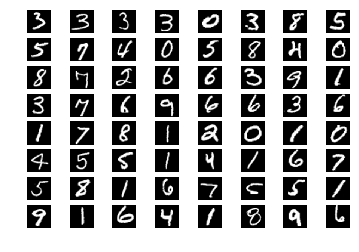

In [28]:
#testing plotter64
d = next(MNISTd)
d = d[0:64, :]
plotter64(d)

Pre-training definition and instantiation of various classes

In [1]:
optlr = 3e-4
optbeta1 = 0.5
IMGSZ = 64

In [56]:
input = torch.FloatTensor(BATCHSZ, nc, IMGSZ, IMGSZ).cuda()
noise = torch.FloatTensor(BATCHSZ, z_indim, 1, 1).cuda()
fixed_noise = torch.FloatTensor(BATCHSZ, z_indim, 1, 1).normal_(0, 1).cuda()
label = torch.FloatTensor(BATCHSZ).cuda()
real_label = 1
fake_label = 0
fixed_noise = Variable(fixed_noise)

In [57]:
#initialising the networks
D = Discriminator()
G = Generator()
D.apply(weights_init)
G.apply(weights_init)
D = D.cuda()
G = G.cuda()
print(D)
print(G)

Discriminator (
  (net): Sequential (
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid ()
  )
)
Generator (
  (net): Sequential (
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  

In [2]:
#instantialing the optimizers
optimizerD = tchoptim.Adam(D.parameters(), lr=optlr, betas=(optbeta1, 0.999))
optimizerG = tchoptim.Adam(G.parameters(), lr=optlr, betas=(optbeta1, 0.999))

NameError: name 'tchoptim' is not defined

In [40]:
criterion = tchnn.BCELoss().cuda()

In [61]:
n_epoch = 100
n_iter = 1

/home/udion/Misc/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[0/100][0/1], Loss_D: 1.5895, Loss_G: 1.4701, D(x): 0.3922, D(G(z)): 0.3016/0.3016
######### generating samples after epoch: 0


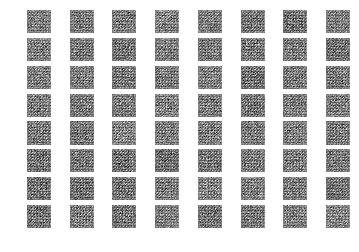

(64, 1, 64, 64)
[1/100][0/1], Loss_D: 1.6973, Loss_G: 1.3973, D(x): 0.3673, D(G(z)): 0.3131/0.3131
######### generating samples after epoch: 1


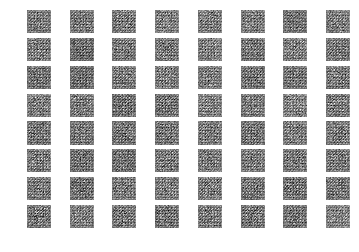

(64, 1, 64, 64)
[2/100][0/1], Loss_D: 1.4785, Loss_G: 1.5003, D(x): 0.4061, D(G(z)): 0.2921/0.2921
######### generating samples after epoch: 2


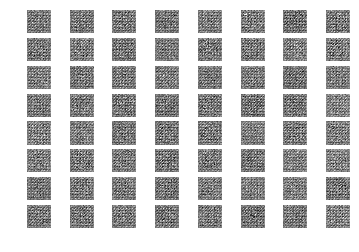

(64, 1, 64, 64)
[3/100][0/1], Loss_D: 1.6299, Loss_G: 1.4369, D(x): 0.3860, D(G(z)): 0.3063/0.3063
######### generating samples after epoch: 3


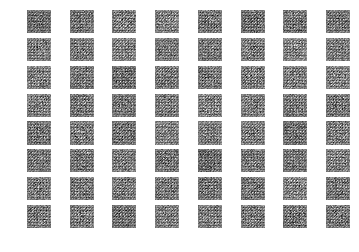

(64, 1, 64, 64)
[4/100][0/1], Loss_D: 1.5911, Loss_G: 1.6269, D(x): 0.3755, D(G(z)): 0.2634/0.2634
######### generating samples after epoch: 4


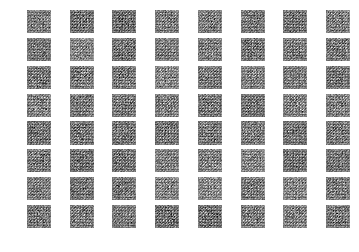

(64, 1, 64, 64)
[5/100][0/1], Loss_D: 1.6975, Loss_G: 1.3863, D(x): 0.3672, D(G(z)): 0.3318/0.3318
######### generating samples after epoch: 5


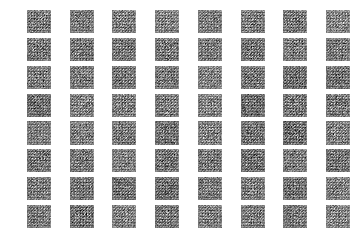

(64, 1, 64, 64)
[6/100][0/1], Loss_D: 1.6171, Loss_G: 1.3956, D(x): 0.3903, D(G(z)): 0.3180/0.3180
######### generating samples after epoch: 6


KeyboardInterrupt: 

In [67]:
for eph in range(n_epoch):
    training_loss = 0
    for itr in range(n_iter):
        #first training the D
        data = next(MNISTd)
        #train with real
        D.zero_grad()
        data = data.reshape(-1,nc,IMGSZ,IMGSZ)
        data = tch.from_numpy(data).cuda().float()
        real_cpu = data
        batch_size = real_cpu.size(0)
        real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = D(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()
        
        #train with fake
        noise.resize_(batch_size, z_indim, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = G(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = D(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        #traininig G
        G.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = D(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        
        if itr%100 == 0:
            print('===> [{}/{}][{}/{}], Loss_D: {:.4f}, Loss_G: {:.4f}, D(x): {:.4f}, D(G(z)): {:.4f}/{:.4f}'.format(
                eph, n_epoch, itr, n_iter, errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
    #generation after this epoch
    print('######### generating samples after epoch: {} ##########'.format(eph))
    rand_inp = torch.FloatTensor(1000, z_indim, 1, 1).cuda()
    rand_inp.resize_(1000, z_indim, 1, 1).normal_(0, 1)
    V_rand_inp = Variable(rand_inp)
    genX = G(V_rand_inp)
    genX_data = genX.data.cpu().numpy()
    genX_datal = list(genX_data)
    genX_datal = random.sample(genX_datal, 64)
    genX_data = np.array(genX_datal)
    plotter64(genX_data)

In [66]:
a = np.random.rand(1000,1,64,64)
print(a.shape)
b = a.reshape(-1,64,64)
print(b.shape)
c = list(a)
len(c[0])

(1000, 1, 64, 64)
(1000, 64, 64)


1